In [50]:
import pandas as pd
import json
import glob
import os
import re
import subprocess
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from datetime import timedelta

RAW_DATA_PATH = "raw-data/merges"
REPO_PATH = "../decidim-govbr-lappis" 

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [51]:
# Agrupamento por Quinzena

def get_commit_timeline(merges_path, repo_path):
    print("--- Gerando Timeline ---")
    ANCHOR_DATE = pd.Timestamp("2025-11-09", tz="UTC")
    
    search_pattern = os.path.join(merges_path, "*")
    dirs = glob.glob(search_pattern)
    commit_hashes = [os.path.basename(d) for d in dirs if os.path.isdir(d)]

    if not commit_hashes:
        print("Nenhum hash encontrado.")
        return pd.DataFrame()

    data_list = []
    for commit_hash in commit_hashes:
        try:
            result = subprocess.run(
                ["git", "show", "-s", "--format=%ci", commit_hash],
                cwd=repo_path,
                capture_output=True, text=True, check=True
            )
            date_str = result.stdout.strip()
            data_list.append({"commit_hash": commit_hash, "date": date_str})
        except Exception:
            pass

    if not data_list:
        return pd.DataFrame()

    df = pd.DataFrame(data_list)
    df['date'] = pd.to_datetime(df['date'], utc=True)
    
    df['days_diff'] = (df['date'] - ANCHOR_DATE).dt.days
    df['group_offset'] = df['days_diff'] // 14

    def calculate_label(offset):
        period_start = ANCHOR_DATE + timedelta(days=offset * 14)
        return period_start.strftime('%Y-%m-%d')

    df['period_label'] = df['group_offset'].apply(calculate_label)
    
    return df.sort_values('date')

df_timeline = get_commit_timeline(RAW_DATA_PATH, REPO_PATH)
df_timeline

--- Gerando Timeline ---


,commit_hash,date,days_diff,group_offset,period_label
33,fc96017f3633cf1aa7503ea0bbc2d32f9f63ab3b,2025-08-25 13:03:52+00:00,-76,-6,2025-08-17
54,95bcaa05f58038658b549caacfd9c08d02046cb3,2025-08-25 13:13:21+00:00,-76,-6,2025-08-17
53,4ce1a2530cf2cddb7704ae24ee9df064974c538f,2025-08-25 13:13:55+00:00,-76,-6,2025-08-17
31,d23e380e3cdeaef4bfb421d0b74b5871cb02df4b,2025-08-25 13:16:34+00:00,-76,-6,2025-08-17
16,ffd2249e9629ad9d371ea86038708e5b57a5b984,2025-08-25 13:33:21+00:00,-76,-6,2025-08-17
...,...,...,...,...,...
59,ea9bab5c0bdafdf3346db1bcf4ddd939852da142,2025-10-30 18:30:40+00:00,-10,-1,2025-10-26
47,591dcb340af64dec721673742315ea1bc562f5ec,2025-10-31 20:04:04+00:00,-9,-1,2025-10-26
43,0ee94b937fc4594150eeaa8e798c02a90d3c02bf,2025-11-04 19:27:08+00:00,-5,-1,2025-10-26
22,c6ceae215ab7379fef62464db376c1405b399f0b,2025-11-09 23:14:42+00:00,0,0,2025-11-09


In [52]:
# Parsers das Ferramentas

def parse_brakeman(base_path):
    print("--- Processando Brakeman ---")
    files = glob.glob(os.path.join(base_path, "*", "artifacts", "brakeman-report.json"))
    results = []

    for filepath in files:
        try:
            path_parts = os.path.normpath(filepath).split(os.sep)
            commit_hash = path_parts[-3]
            
            with open(filepath, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            row = {'commit_hash': commit_hash}
            warnings = data.get("warnings", [])
            
            if warnings:
                df_temp = pd.DataFrame(warnings)
                if "confidence" in df_temp.columns:
                    counts = df_temp['confidence'].value_counts().to_dict()
                    row.update({f"brakeman_{k}": v for k, v in counts.items()})
            
            row['brakeman_total'] = data.get("scan_info", {}).get("security_warnings", 0)
            results.append(row)
        except Exception:
            continue
            
    return pd.DataFrame(results).fillna(0) if results else pd.DataFrame()

def parse_trivy(base_path):
    print("--- Processando Trivy ---")
    files = glob.glob(os.path.join(base_path, "*", "artifacts", "trivy-report.json"))
    results = []

    for filepath in files:
        try:
            path_parts = os.path.normpath(filepath).split(os.sep)
            commit_hash = path_parts[-3]
            
            with open(filepath, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            severities = []
            for res in data.get("Results", []):
                for vuln in res.get("Vulnerabilities", []):
                    severities.append(vuln.get("Severity"))
                for secret in res.get("Secrets", []):
                    severities.append(secret.get("Severity"))
            
            row = {'commit_hash': commit_hash}
            if severities:
                counts = pd.Series(severities).value_counts().to_dict()
                row.update({f"trivy_{k}": v for k, v in counts.items()})
                row['trivy_total'] = len(severities)
            else:
                row['trivy_total'] = 0
            results.append(row)
        except Exception:
            continue

    return pd.DataFrame(results).fillna(0) if results else pd.DataFrame()

def parse_zap(base_path):
    print("--- Processando ZAP ---")
    files = glob.glob(os.path.join(base_path, "*", "artifacts", "zap-report.json"))
    results = []
    
    risk_map = {"3": "High", "2": "Medium", "1": "Low", "0": "Informational"}

    for filepath in files:
        try:
            path_parts = os.path.normpath(filepath).split(os.sep)
            commit_hash = path_parts[-3]
            
            with open(filepath, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            alerts = data.get("site", [{}])[0].get("alerts", [])
            row = {'commit_hash': commit_hash}
            total = 0
            
            if alerts:
                for alert in alerts:
                    risk_level = risk_map.get(alert.get("riskcode"), "Unknown")
                    count = int(alert.get("count", 0))
                    col_name = f"zap_{risk_level}"
                    row[col_name] = row.get(col_name, 0) + count
                    total += count
            
            row['zap_total'] = total
            results.append(row)
        except Exception:
            continue

    return pd.DataFrame(results).fillna(0) if results else pd.DataFrame()

def parse_pipeline_logs(base_path):
    print("--- Processando Logs da Pipeline (Warn/Fail) ---")
    search_pattern = os.path.join(base_path, "*", "logs_pipeline", "pipeline_summary.txt")
    files = glob.glob(search_pattern)
    
    results = []

    for filepath in files:
        try:
            path_parts = os.path.normpath(filepath).split(os.sep)
            commit_hash = path_parts[-3] 

            with open(filepath, 'r', encoding='utf-8') as f:
                content = f.read()
                
            has_fail = "FAIL" in content
            has_warn = "WARN" in content
            
            status_code = 1 if (has_fail or has_warn) else 0
            
            results.append({
                'commit_hash': commit_hash,
                'pipeline_has_issue': status_code
            })

        except Exception:
            continue

    if not results:
        return pd.DataFrame(columns=['commit_hash', 'pipeline_has_issue'])
        
    return pd.DataFrame(results)

def parse_dependency_counts(repo_path, commit_hashes):
    print("--- Contando Bibliotecas (Gemfile.lock e package-lock.json) ---")
    
    results = []
    gem_regex = re.compile(r'^\s{4}[\w\-_]+ \(')

    for commit_hash in commit_hashes:
        total_libs = 0
        gems_count = 0
        npm_count = 0
        
        try:
            cmd = ["git", "show", f"{commit_hash}:Gemfile.lock"]
            output = subprocess.check_output(cmd, cwd=repo_path, stderr=subprocess.DEVNULL).decode('utf-8')
            gems_count = len([line for line in output.splitlines() if gem_regex.match(line)])
        except subprocess.CalledProcessError:
            pass

        try:
            cmd = ["git", "show", f"{commit_hash}:package-lock.json"]
            output = subprocess.check_output(cmd, cwd=repo_path, stderr=subprocess.DEVNULL).decode('utf-8')
            pkg_lock = json.loads(output)
            
            if "packages" in pkg_lock:
                npm_count = len([k for k in pkg_lock["packages"].keys() if k != ""])
            elif "dependencies" in pkg_lock:
                npm_count = len(pkg_lock["dependencies"])
                
        except (subprocess.CalledProcessError, json.JSONDecodeError):
            try:
                cmd = ["git", "show", f"{commit_hash}:package.json"]
                output = subprocess.check_output(cmd, cwd=repo_path, stderr=subprocess.DEVNULL).decode('utf-8')
                pkg_json = json.loads(output)
                npm_count = len(pkg_json.get('dependencies', {})) + len(pkg_json.get('devDependencies', {}))
            except:
                pass

        total_libs = gems_count + npm_count

        results.append({
            'commit_hash': commit_hash,
            'total_libs': total_libs,
            'ruby_libs': gems_count,
            'npm_libs': npm_count
        })

    return pd.DataFrame(results)

In [53]:
# Gera Timeline

df_timeline = get_commit_timeline(RAW_DATA_PATH, REPO_PATH)

if df_timeline.empty:
    print("ERRO: Não foi possível gerar a timeline. Verifique o REPO_PATH.")
else:
    unique_hashes = df_timeline['commit_hash'].unique()
    df_brakeman = parse_brakeman(RAW_DATA_PATH)
    df_trivy = parse_trivy(RAW_DATA_PATH)
    df_zap = parse_zap(RAW_DATA_PATH)
    df_logs = parse_pipeline_logs(RAW_DATA_PATH)
    df_deps = parse_dependency_counts(REPO_PATH, unique_hashes)

    df_final = df_timeline.merge(df_brakeman, on='commit_hash', how='left')
    df_final = df_final.merge(df_trivy, on='commit_hash', how='left')
    df_final = df_final.merge(df_zap, on='commit_hash', how='left')
    df_final = df_final.merge(df_logs, on='commit_hash', how='left')
    df_final = df_final.merge(df_deps, on='commit_hash', how='left')

    numeric_cols = df_final.select_dtypes(include=['number']).columns
    cols_to_fill = [c for c in numeric_cols if c not in ['days_diff', 'group_offset', 'pipeline_has_issue']]
    df_final[cols_to_fill] = df_final[cols_to_fill].fillna(0)

    df_final['vuln_density_pct'] = df_final.apply(
        lambda x: (x['trivy_total'] / x['total_libs'] * 100) if x['total_libs'] > 0 else 0, 
        axis=1
    )

    print(f"\nDataset Integrado Criado: {df_final.shape[0]} commits processados.")
    
    display(df_final.head())

--- Gerando Timeline ---
--- Processando Brakeman ---
--- Processando Trivy ---
--- Processando ZAP ---
--- Processando Logs da Pipeline (Warn/Fail) ---
--- Contando Bibliotecas (Gemfile.lock e package-lock.json) ---

Dataset Integrado Criado: 61 commits processados.


,commit_hash,date,days_diff,group_offset,period_label,brakeman_Medium,brakeman_High,brakeman_Weak,brakeman_total,trivy_MEDIUM,trivy_HIGH,trivy_LOW,trivy_CRITICAL,trivy_total,zap_Medium,zap_Low,zap_Informational,zap_total,pipeline_has_issue,total_libs,ruby_libs,npm_libs,vuln_density_pct
0,fc96017f3633cf1aa7503ea0bbc2d32f9f63ab3b,2025-08-25 13:03:52+00:00,-76,-6,2025-08-17,8,6,4,18,59,37,12,5,113,25.0,74.0,46.0,145.0,1,381,340,41,29.658793
1,95bcaa05f58038658b549caacfd9c08d02046cb3,2025-08-25 13:13:21+00:00,-76,-6,2025-08-17,8,6,4,18,59,37,12,5,113,26.0,74.0,46.0,146.0,1,381,340,41,29.658793
2,4ce1a2530cf2cddb7704ae24ee9df064974c538f,2025-08-25 13:13:55+00:00,-76,-6,2025-08-17,8,6,4,18,59,37,12,5,113,25.0,79.0,45.0,149.0,1,381,340,41,29.658793
3,d23e380e3cdeaef4bfb421d0b74b5871cb02df4b,2025-08-25 13:16:34+00:00,-76,-6,2025-08-17,8,6,4,18,59,37,12,5,113,25.0,74.0,45.0,144.0,1,381,340,41,29.658793
4,ffd2249e9629ad9d371ea86038708e5b57a5b984,2025-08-25 13:33:21+00:00,-76,-6,2025-08-17,8,6,4,18,59,37,12,5,113,26.0,74.0,46.0,146.0,1,381,340,41,29.658793


In [54]:
# Plotagem

if 'df_final' in locals() and not df_final.empty:
    
    cols_to_sum = [c for c in df_final.columns if 
                   df_final[c].dtype in ['float64', 'int64'] 
                   and 'days_diff' not in c
                   and 'group_offset' not in c
                   and 'vuln_density_pct' not in c
                   and 'total_libs' not in c
                   ]
    
    agg_dict = {c: 'sum' for c in cols_to_sum}
    
    agg_dict['period_label'] = 'first'
    agg_dict['commit_hash'] = 'count'
    agg_dict['total_libs'] = 'mean'
    
    df_grouped = df_final.groupby('group_offset').agg(agg_dict).rename(columns={
        'commit_hash': 'commit_count',
        'total_libs': 'avg_libs_per_commit'
    }).sort_index()

    
    def get_sum(df, term):
        cols = [c for c in df.columns if term.lower() in c.lower() and 'total' not in c.lower()]
        return df[cols].sum(axis=1) if cols else 0

    df_grouped['Unified_High_Critical'] = get_sum(df_grouped, 'High') + get_sum(df_grouped, 'Critical')
    df_grouped['Unified_Medium'] = get_sum(df_grouped, 'Medium')
    df_grouped['Unified_Low'] = get_sum(df_grouped, 'Low')
    
    df_grouped['Total_All_Brakeman'] = df_grouped.get('brakeman_total', 0)
    df_grouped['Total_All_Trivy'] = df_grouped.get('trivy_total', 0)
    df_grouped['Total_All_ZAP'] = df_grouped.get('zap_total', 0)

    df_grouped['avg_vuln_density'] = df_final.groupby('group_offset')['vuln_density_pct'].mean()
    

    print("Dados agrupados e calculados.")
    display(df_grouped[['period_label', 'commit_count', 'Unified_High_Critical', 'avg_vuln_density']].tail())

else:
    print("Dataset vazio.")

Dados agrupados e calculados.


,period_label,commit_count,Unified_High_Critical,avg_vuln_density
group_offset,,,,
-4,2025-09-14,5,240,29.658793
-3,2025-09-28,5,240,29.658793
-2,2025-10-12,17,816,29.658793
-1,2025-10-26,13,619,29.587124
0,2025-11-09,2,94,29.581152


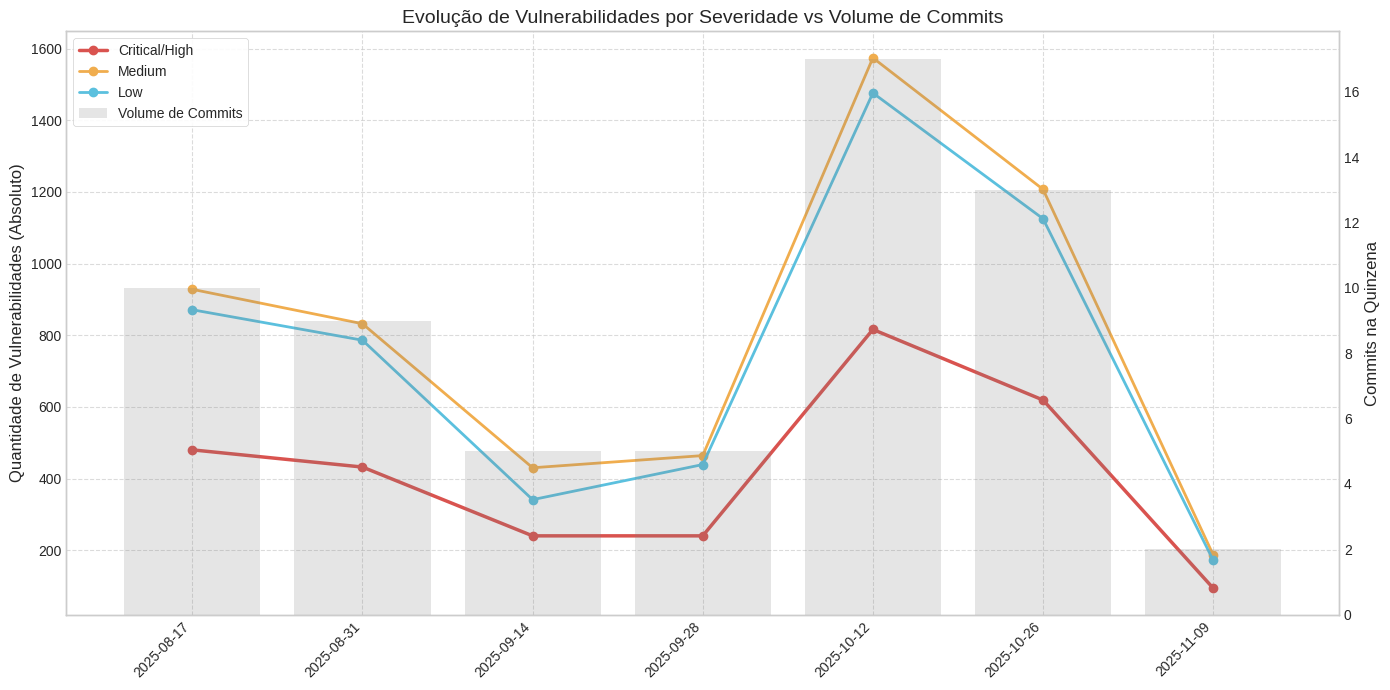

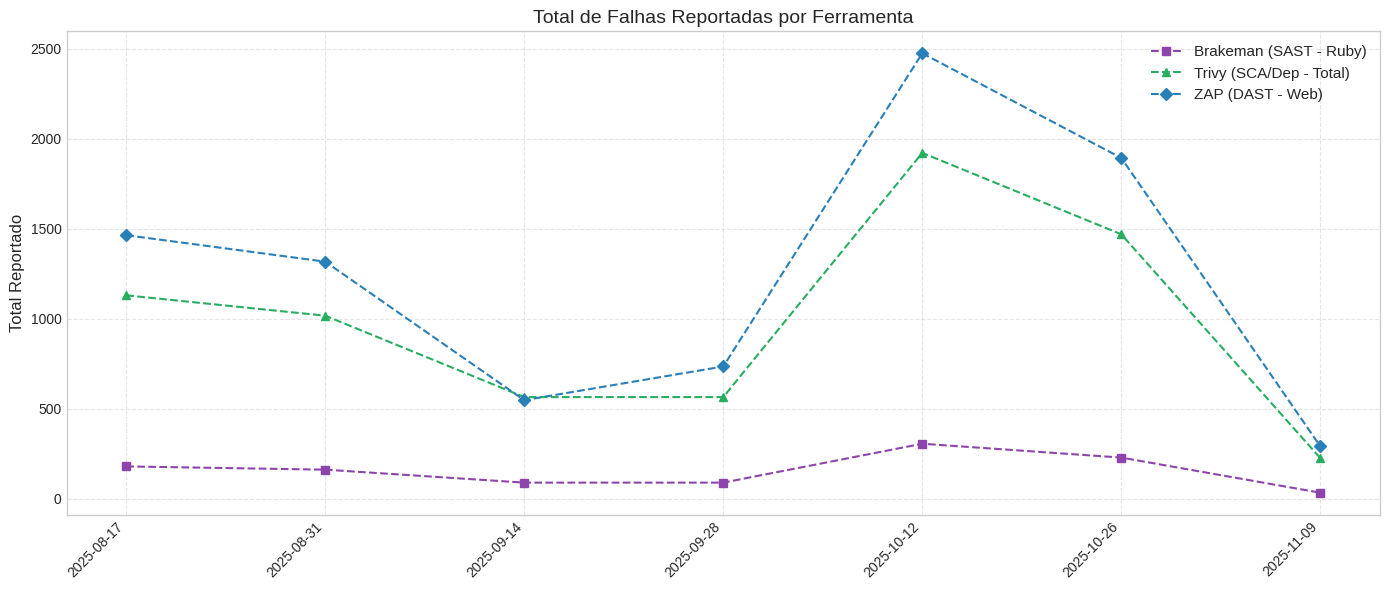

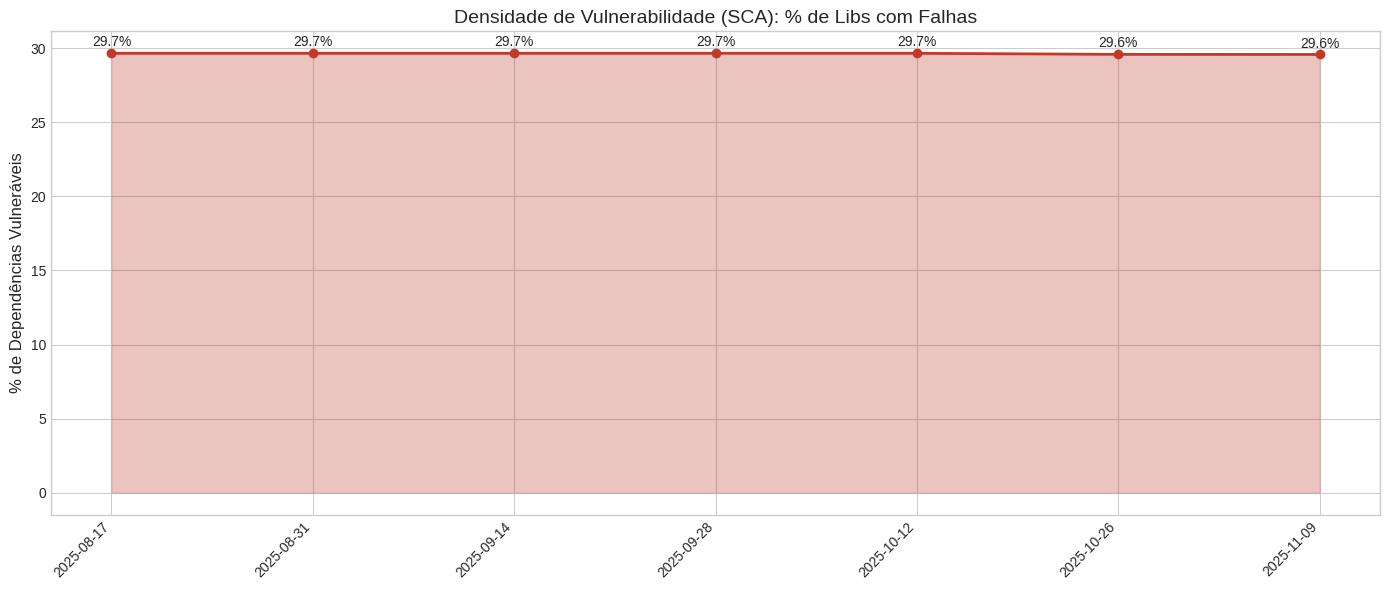

In [55]:
# Visualização

if 'df_grouped' in locals() and not df_grouped.empty:
    plt.style.use('seaborn-v0_8-whitegrid') 
    
    x = range(len(df_grouped))
    labels = df_grouped['period_label']

    # GRÁFICO 1: Severidade vs Volume de Trabalho
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.set_zorder(2) 
    ax1.patch.set_visible(False)

    # Linhas de Vulnerabilidade 
    ax1.plot(x, df_grouped['Unified_High_Critical'], 'o-', color='#d9534f', linewidth=2.5, label='Critical/High')
    ax1.plot(x, df_grouped['Unified_Medium'], 'o-', color='#f0ad4e', linewidth=2, label='Medium')
    ax1.plot(x, df_grouped['Unified_Low'], 'o-', color='#5bc0de', linewidth=2, label='Low')
    
    ax1.set_ylabel('Quantidade de Vulnerabilidades (Absoluto)', fontsize=12)
    ax1.set_title('Evolução de Vulnerabilidades por Severidade vs Volume de Commits', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Barras de Volume
    ax2 = ax1.twinx()
    ax2.bar(x, df_grouped['commit_count'], color='gray', alpha=0.2, label='Volume de Commits', zorder=1)
    ax2.set_ylabel('Commits na Quinzena', fontsize=12)
    ax2.grid(False)

    # Legenda Combinada
    lines1, lab1 = ax1.get_legend_handles_labels()
    lines2, lab2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, lab1 + lab2, loc='upper left', frameon=True, fancybox=True, framealpha=0.9)

    plt.tight_layout()
    plt.show()

    # GRÁFICO 2: Ferramentas (Comparativo)
    fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.plot(x, df_grouped['Total_All_Brakeman'], 's--', color='#8e44ad', label='Brakeman (SAST - Ruby)')
    ax.plot(x, df_grouped['Total_All_Trivy'], '^--', color='#27ae60', label='Trivy (SCA/Dep - Total)')
    ax.plot(x, df_grouped['Total_All_ZAP'], 'D--', color='#2980b9', label='ZAP (DAST - Web)')

    ax.set_title('Total de Falhas Reportadas por Ferramenta', fontsize=14)
    ax.set_ylabel('Total Reportado', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend(fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # GRÁFICO 3: Densidade de Vulnerabilidade
    if 'avg_vuln_density' in df_grouped.columns:
        fig, ax = plt.subplots(figsize=(14, 6))
        
        ax.fill_between(x, df_grouped['avg_vuln_density'], color='#c0392b', alpha=0.3)
        ax.plot(x, df_grouped['avg_vuln_density'], 'o-', color='#c0392b', linewidth=2, label='% Bibliotecas Vulneráveis')
        
        ax.set_title('Densidade de Vulnerabilidade (SCA): % de Libs com Falhas', fontsize=14)
        ax.set_ylabel('% de Dependências Vulneráveis', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45, ha='right')
        
        for i, val in enumerate(df_grouped['avg_vuln_density']):
            ax.annotate(f"{val:.1f}%", (x[i], val), xytext=(0, 5), textcoords='offset points', ha='center')

        plt.tight_layout()
        plt.show()

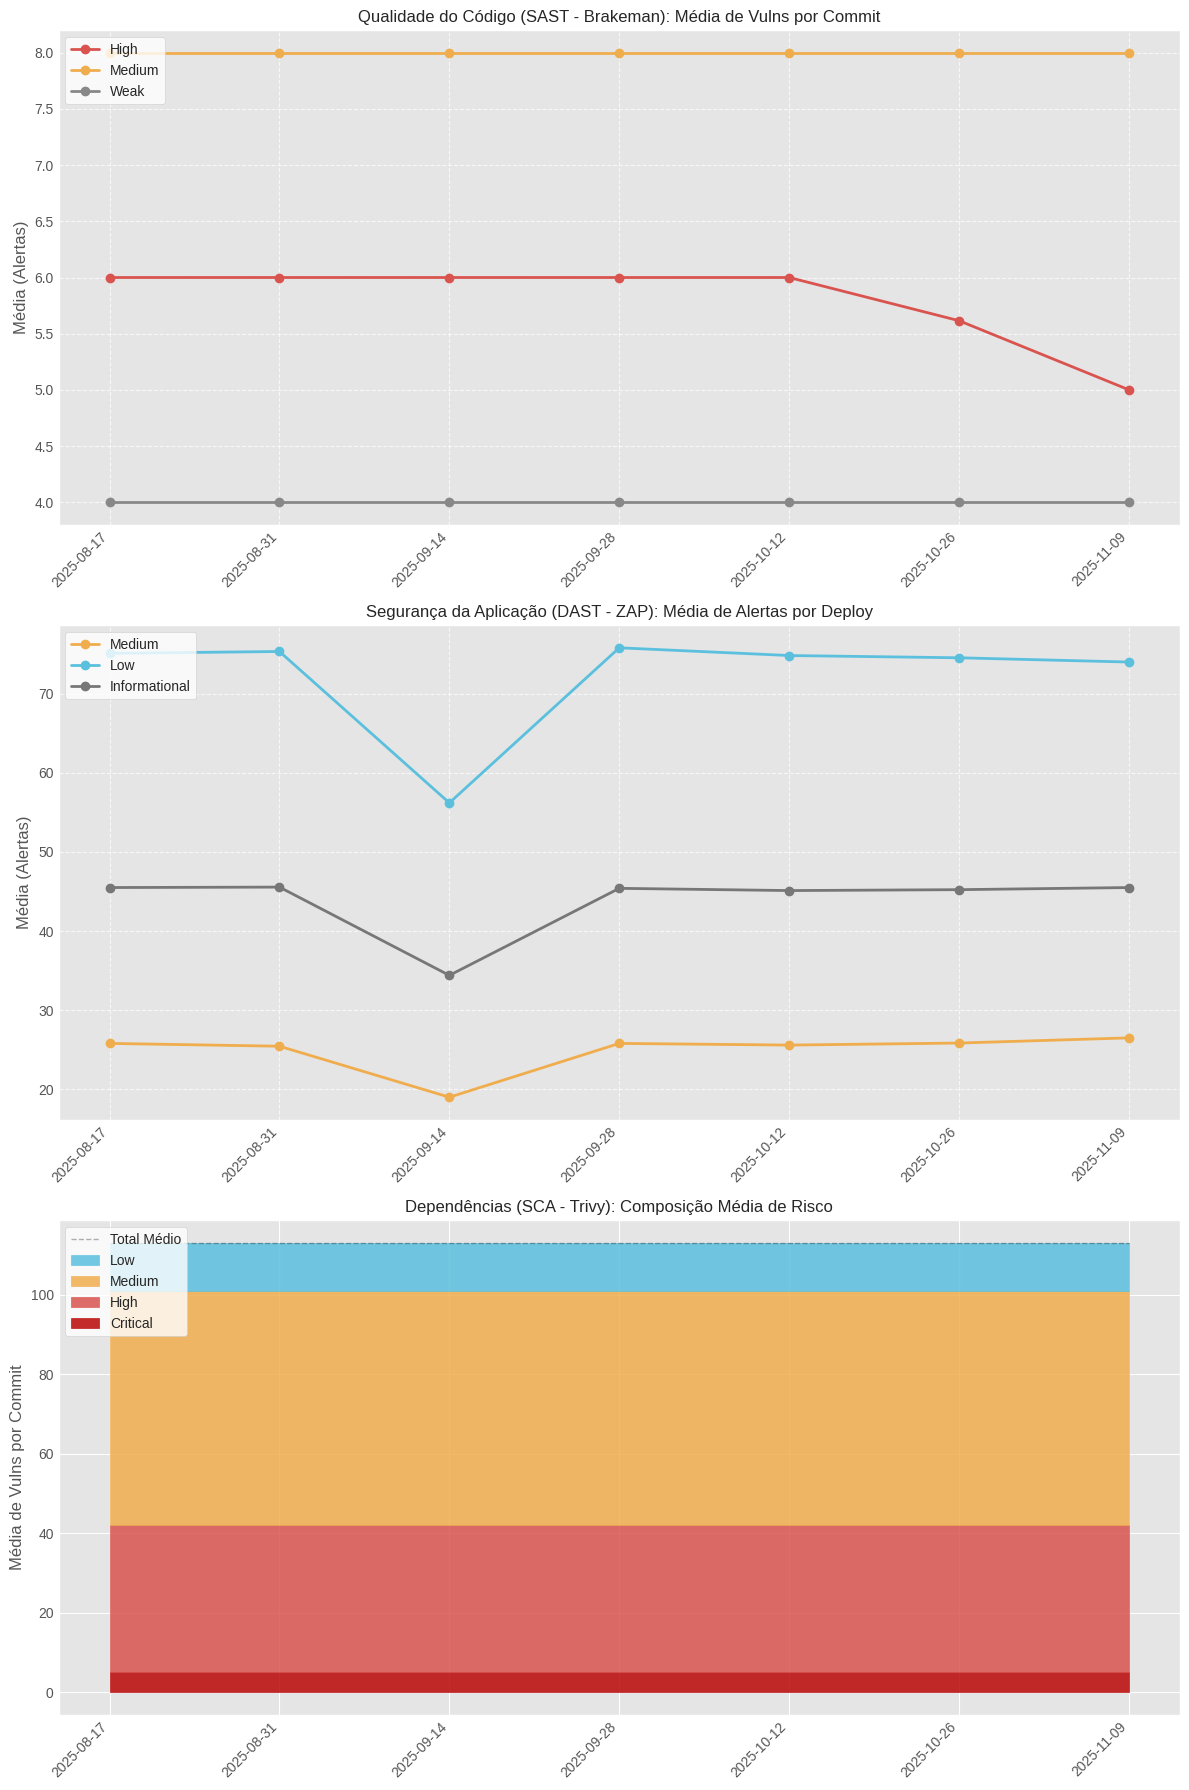

In [56]:
# Agrupamento pela Média

grouped_data = df_final.groupby('group_offset').mean(numeric_only=True)

labels = df_final.groupby('group_offset')['period_label'].first()
x_idx = range(len(labels))

plt.style.use('ggplot')

colors_severity = {
    'Critical': '#ba0606',
    'High': '#d9534f',
    'Medium': '#f0ad4e',
    'Low': '#5bc0de',
    'Weak': '#888888', 
    'Informational': '#777777',
    'Unknown': '#000000'
}

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

def plot_trend_lines(ax, df_grouped, prefix, title, ylabel):
    cols = [c for c in df_grouped.columns if c.startswith(prefix) and 'total' not in c]
    priority = ['Critical', 'High', 'Medium', 'Low', 'Informational']
    sorted_cols = sorted(cols, key=lambda x: next((i for i, p in enumerate(priority) if p in x), 99))

    for col in sorted_cols:
        severity_name = col.split('_')[-1]
        color = colors_severity.get(severity_name, '#333333')
        ax.plot(x_idx, df_grouped[col], marker='o', linewidth=2, label=severity_name, color=color)

    ax.set_title(title, fontsize=12)
    ax.set_ylabel(ylabel)
    ax.set_xticks(x_idx)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend(loc='upper left', frameon=True, facecolor='white', framealpha=0.8)
    ax.grid(True, linestyle='--', alpha=0.7)

# GRÁFICO 1: BRAKEMAN
plot_trend_lines(ax1, grouped_data, 'brakeman_', 
                 'Qualidade do Código (SAST - Brakeman): Média de Vulns por Commit', 
                 'Média (Alertas)')

# GRÁFICO 2: ZAP
plot_trend_lines(ax2, grouped_data, 'zap_', 
                 'Segurança da Aplicação (DAST - ZAP): Média de Alertas por Deploy', 
                 'Média (Alertas)')

# GRÁFICO 3: TRIVY
cols_trivy = [c for c in grouped_data.columns if c.startswith('trivy_') and 'total' not in c]
priority_trivy = ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW']
cols_trivy = sorted(cols_trivy, key=lambda x: next((i for i, p in enumerate(priority_trivy) if p.upper() in x.upper()), 99))

bottom_val = 0
for col in cols_trivy:
    severity_name = col.split('_')[-1]
    sev_key = severity_name.capitalize() 
    if sev_key == 'Critical': sev_key = 'Critical'
    
    color = colors_severity.get(sev_key, '#333333')
    
    ax3.fill_between(x_idx, bottom_val, bottom_val + grouped_data[col], 
                     label=sev_key, color=color, alpha=0.85)
    bottom_val += grouped_data[col]

ax3.plot(x_idx, bottom_val, color='black', linestyle='--', alpha=0.3, linewidth=1, label='Total Médio')

ax3.set_title('Dependências (SCA - Trivy): Composição Média de Risco', fontsize=12)
ax3.set_ylabel('Média de Vulns por Commit')
ax3.set_xticks(x_idx)
ax3.set_xticklabels(labels, rotation=45, ha='right')

handles, labels_leg = ax3.get_legend_handles_labels()
ax3.legend(handles[::-1], labels_leg[::-1], loc='upper left', frameon=True, facecolor='white')

plt.tight_layout()
plt.show()

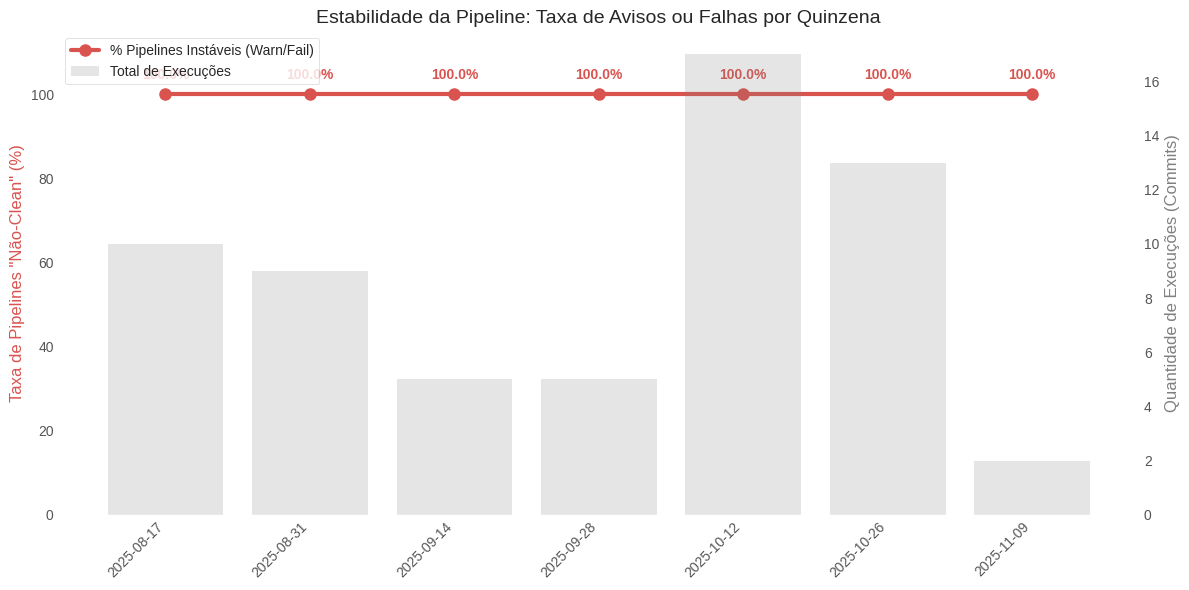

In [57]:
# GRÁFICO: Taxa de Pipelines com WARN/FAIL

if 'df_final' in locals() and not df_final.empty:
    plt.style.use('ggplot')
    
    df_rate = df_final.groupby('group_offset').agg({
        'pipeline_has_issue': ['count', 'sum', 'mean'],
        'period_label': 'first'
    })
    
    df_rate.columns = ['_'.join(col).strip() for col in df_rate.columns.values]
    
    df_rate = df_rate.rename(columns={
        'pipeline_has_issue_mean': 'failure_rate',
        'pipeline_has_issue_count': 'total_runs',
        'period_label_first': 'period_label'
    }).sort_index()

    df_rate['failure_rate_pct'] = df_rate['failure_rate'] * 100

    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    ax1.set_zorder(2)
    ax1.patch.set_visible(False)

    x = range(len(df_rate))
    labels = df_rate['period_label']

    ax1.plot(x, df_rate['failure_rate_pct'], marker='o', markersize=8, 
             color='#d9534f', linewidth=3, label='% Pipelines Instáveis (Warn/Fail)')
    
    ax1.set_ylim(0, 115)
    ax1.set_ylabel('Taxa de Pipelines "Não-Clean" (%)', fontsize=12, color='#d9534f')
    ax1.set_title('Estabilidade da Pipeline: Taxa de Avisos ou Falhas por Quinzena', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.grid(True, linestyle='--', alpha=0.5)

    for i, v in enumerate(df_rate['failure_rate_pct']):
        if v > 0:
            ax1.text(i, v + 3, f"{v:.1f}%", ha='center', va='bottom', 
                     color='#d9534f', fontweight='bold', fontsize=10)

    ax2 = ax1.twinx()
    ax2.bar(x, df_rate['total_runs'], color='gray', alpha=0.2, label='Total de Execuções', zorder=1)
    ax2.set_ylabel('Quantidade de Execuções (Commits)', fontsize=12, color='gray')
    ax2.grid(False)

    lines1, lab1 = ax1.get_legend_handles_labels()
    lines2, lab2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, lab1 + lab2, loc='upper left', frameon=True, facecolor='white')

    plt.tight_layout()
    plt.show()

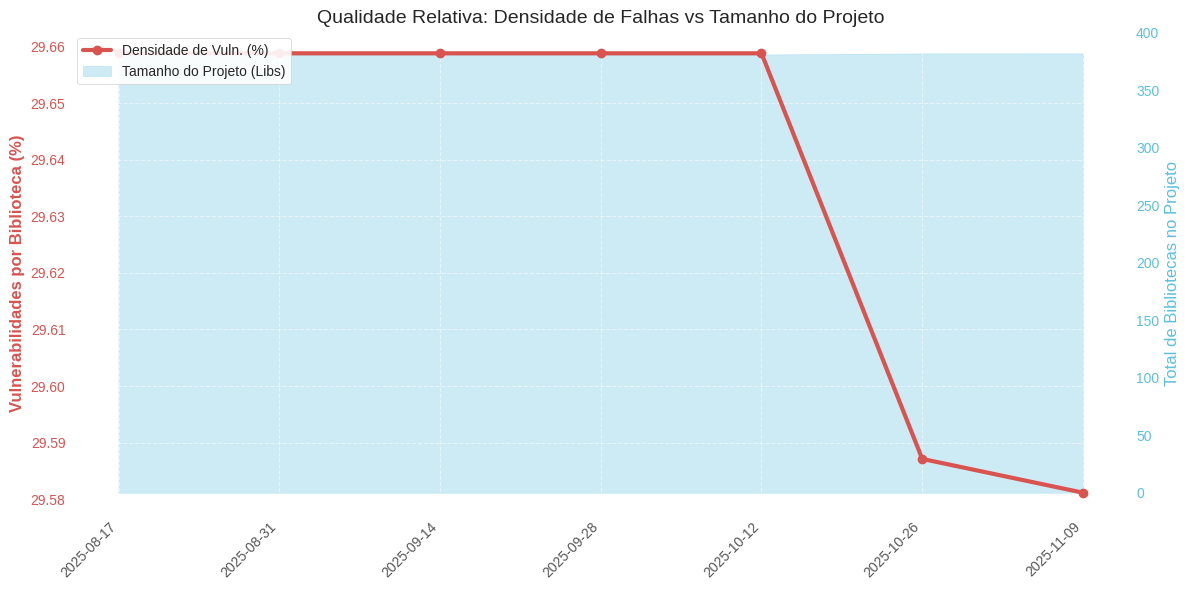

In [58]:
if 'df_final' in locals() and not df_final.empty:
    plt.style.use('ggplot')
    
    df_grouped = df_final.groupby('group_offset').agg({
        'vuln_density_pct': 'mean',
        'total_libs': 'mean', 
        'period_label': 'first'
    })
    
    x = range(len(df_grouped))
    labels = df_grouped['period_label']

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_zorder(2)
    ax1.patch.set_visible(False)

    color_line = '#d9534f' 
    ax1.plot(x, df_grouped['vuln_density_pct'], marker='o', color=color_line, linewidth=3, label='Densidade de Vulnerabilidades (%)')
    
    ax1.set_ylabel('Vulnerabilidades por Biblioteca (%)', color=color_line, fontsize=12, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=color_line)
    ax1.set_title('Qualidade Relativa: Densidade de Falhas vs Tamanho do Projeto', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.grid(True, linestyle='--', alpha=0.5)

    ax2 = ax1.twinx()
    ax2.set_zorder(1)
    
    color_area = '#5bc0de'
    ax2.fill_between(x, df_grouped['total_libs'], color=color_area, alpha=0.3, label='Média de Bibliotecas Usadas')
    
    ax2.set_ylabel('Total de Bibliotecas no Projeto', color=color_area, fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color_area)
    ax2.grid(False)

    legend_elements = [
        Line2D([0], [0], color=color_line, lw=3, marker='o', label='Densidade de Vuln. (%)'),
        Patch(facecolor=color_area, edgecolor=color_area, alpha=0.3, label='Tamanho do Projeto (Libs)')
    ]
    
    ax1.legend(handles=legend_elements, loc='upper left', frameon=True, facecolor='white', framealpha=0.9)

    plt.tight_layout()
    plt.show()